# Subsetting STOFS-3D files and creating an hgrid file for that

This is for supporting Harmful Algal Bloom Forecasting Branch and Modeling Team.

**To run the code please follow the steps below:**



## 1- Create a Python Virtual Environment on Your Machine

- If you haven't already installed Miniconda, please use the following commands to download and install it:

```
wget -nH -m -nd https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
bash Miniconda3-latest-Linux-x86_64.sh
```

- OCSMesh is the package we use to create mesh files for STOFS subset data.
  Run the following commands line by line to download the OCSMesh environment file and create and activate a Python virtual environment. 

- Replace your-env-name with your desired environment name:

```
wget https://raw.githubusercontent.com/noaa-ocs-modeling/OCSMesh/main/environment.yml
conda env create -f environment.yml -n your-env-name
conda activate your-env-name
```

## 2- Install the Required Libraries in the Python Environment

- Run the following commands to install the necessary libraries and packages:


```
conda install -y -c conda-forge jigsawpy
pip install ocsmesh
conda install jupyter
pip install thalassa
conda install -c conda-forge geopandas
pip install s3fs
```

## 3- Run the Following Cell to Patch Thalassa utils.py file for Subsetting STOFS Data Using a Shapefile


In [ ]:
import os
import sys
import importlib.util

CUSTOM_CROP_FUNCTION = '''
def crop(
    ds: xarray.Dataset,
    bbox: shapely.Polygon,
) -> xarray.Dataset:
    """
    Crop the dataset using the provided `bbox`, which can be a bounding box or an arbitrary polygon.

    Example:
        ```python
        import thalassa
        from shapely.geometry import box, Polygon

        ds = thalassa.open_dataset("some_netcdf.nc")

        # Bounding box
        bbox = box(0, 0, 1, 1)

        # Arbitrary polygon
        bbox = Polygon([
            (10, 40),
            (20, 40),
            (15, 50),
        ])

        ds = thalassa.crop(ds, bbox)
        ```

    Parameters:
        ds: The xarray.Dataset to crop.
        bbox: A Shapely polygon whose geometry will be used to crop `ds`.

    Returns:
        Cropped xarray.Dataset.
    """
    import numpy as np
    import numpy_indexed as npi
    import shapely.geometry
    import numpy.typing as npt

    bbox = resolve_bbox(bbox)

    node_points = [
        shapely.geometry.Point(lon, lat)
        for lon, lat in zip(ds.lon.values, ds.lat.values)
    ]
    mask = np.array([bbox.contains(point) for point in node_points])
    indices_of_nodes_in_bbox = np.where(mask)[0]

    triface_nodes = ds.triface_nodes.values
    triangle_mask = np.all(np.isin(triface_nodes, indices_of_nodes_in_bbox), axis=1)
    indices_of_triface_nodes_in_bbox = np.where(triangle_mask)[0]

    ds = ds.isel(node=indices_of_nodes_in_bbox, triface=indices_of_triface_nodes_in_bbox)

    remapped_nodes = np.arange(len(indices_of_nodes_in_bbox))
    remapped_triface_nodes = np.c_[
        npi.remap(ds.triface_nodes[:, 0], indices_of_nodes_in_bbox, remapped_nodes),
        npi.remap(ds.triface_nodes[:, 1], indices_of_nodes_in_bbox, remapped_nodes),
        npi.remap(ds.triface_nodes[:, 2], indices_of_nodes_in_bbox, remapped_nodes),
    ]
    ds["triface_nodes"] = (("triface", "three"), remapped_triface_nodes)

    return ds
'''.strip()


def patch_thalassa_crop():
    try:
        # Locate installed thalassa package
        spec = importlib.util.find_spec("thalassa")
        thalassa_path = os.path.dirname(spec.origin)
        utils_path = os.path.join(thalassa_path, "utils.py")
        if not os.path.exists(utils_path):
            print(f"utils.py not found at {utils_path}")
            sys.exit(1)

        with open(utils_path, "r") as f:
            content = f.read()

        # Ensure `import numpy.typing as npt` is at top-level
        lines = content.splitlines()
        for i, line in enumerate(lines):
                if line.strip().startswith("import") or line.strip().startswith("from"):
                    continue
                # Insert just before first non-import
                lines.insert(i, "import numpy.typing as npt")
                content = "\n".join(lines)
                print("Added 'import numpy.typing as npt'")
                break

        # Find and replace the current crop() function
        start = content.find("def crop(")
        end = content.find("return ds", start)
        end = content.find("\n", end) + 1

        # Replace old crop() with new one to crop polygon 
        new_content = content[:start] + CUSTOM_CROP_FUNCTION + "\n\n" + content[end:]

        with open(utils_path, "w") as f:
            f.write(new_content)

        print("Successfully patched crop() in thalassa/utils.py")

    except Exception as e:
        print(f"Error: {e}")
        sys.exit(1)


if __name__ == "__main__":
    patch_thalassa_crop()

## 4- Run the Following Cell to Import the Required Libraries


In [17]:
# Import required libraries
import os
import xarray as xr
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon
import fsspec
fs = fsspec.filesystem("s3", anon=True)
import numpy.typing as npt
import thalassa  
from thalassa import api  
from thalassa import normalization
from thalassa import utils
import ocsmesh


## 5- Define the Input and Run the Code
This code is designed to subset STOFS-3D-Atlantic forecast data for specific variables, date, and geographic areas that you specify.
You will need to provide a shapefile that defines the area of interest for subsetting the data.
Additionally, another shapefile is used to define the location of boundary nodes.

Please download the example shapefiles from the HAB_Sample directory.

Below is an example of subsetting data for the Potomac River area.

A screenshot of the STOFS subset data and the corresponding grid file is also provided.                                                                                                                          
                                                                                                                                                        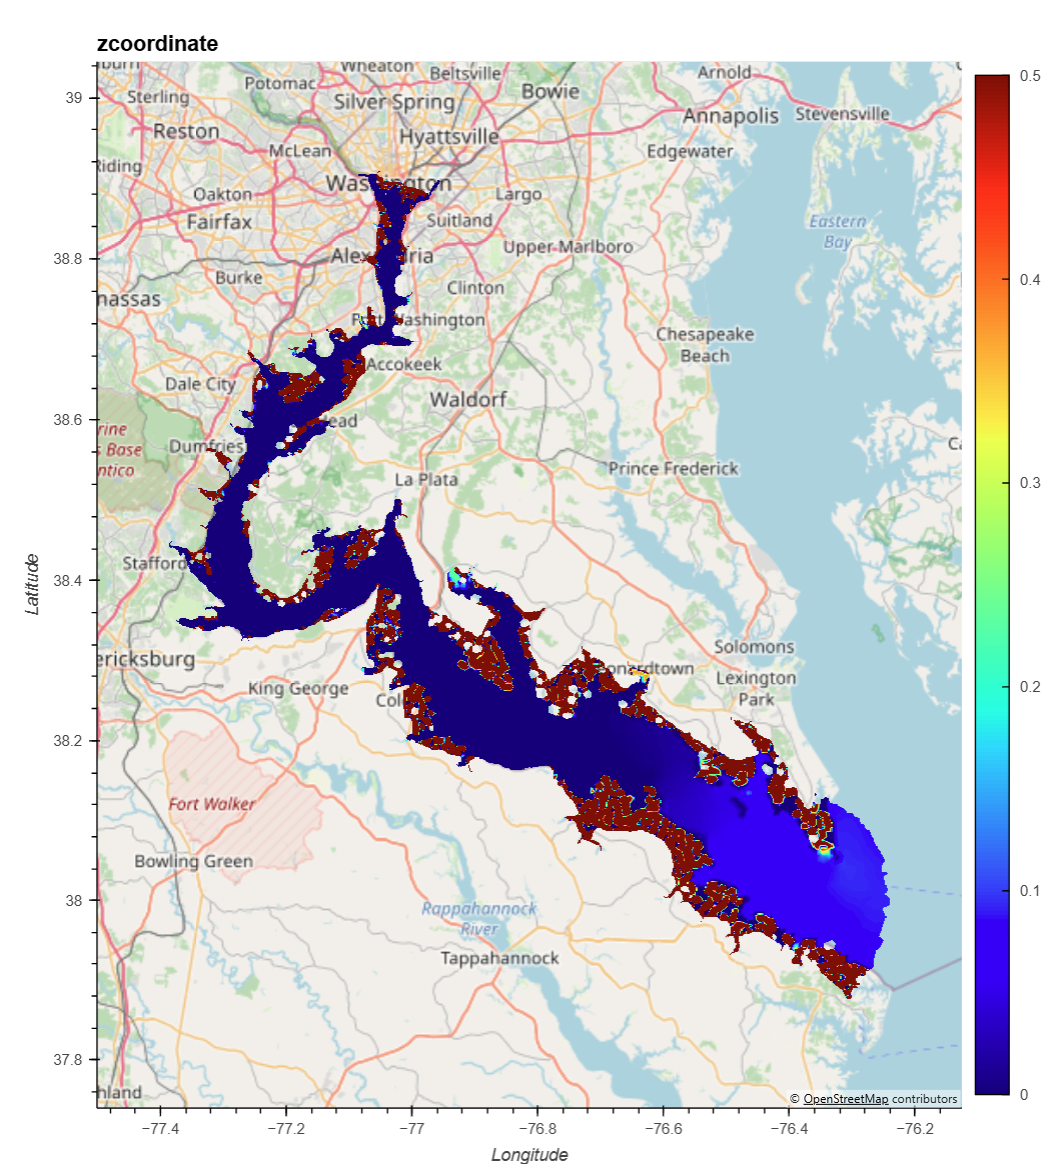

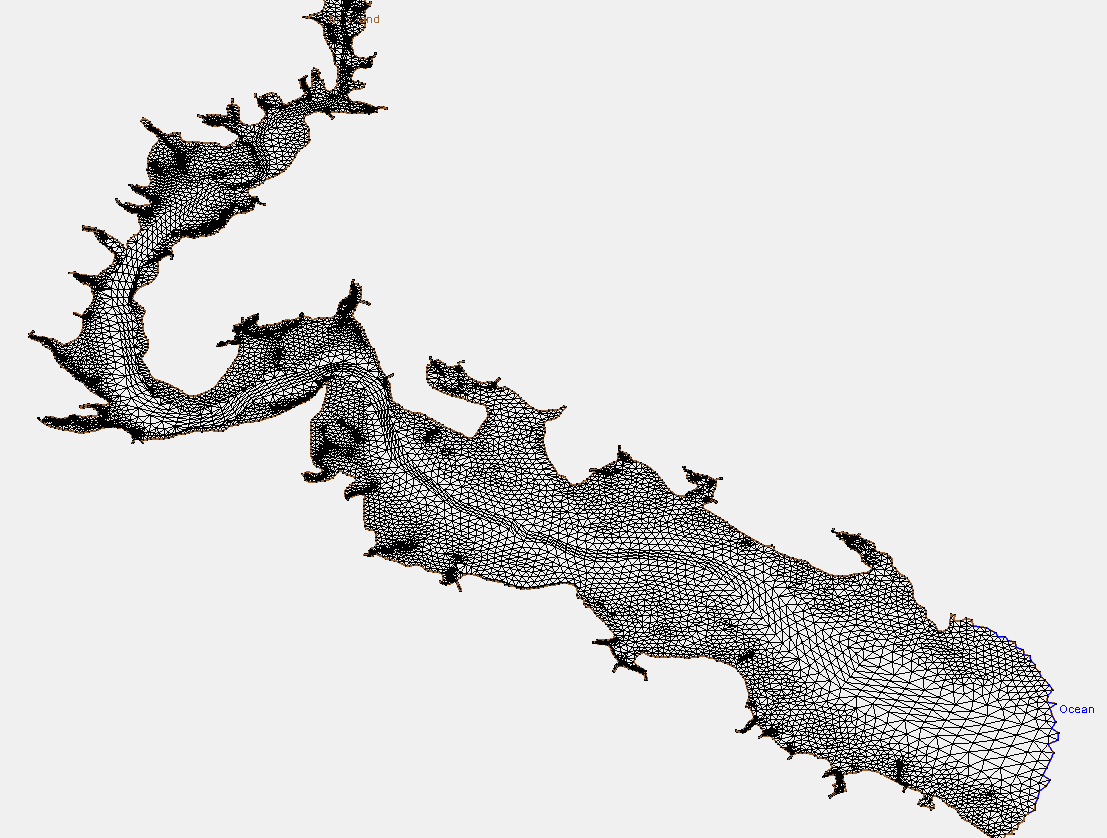                                                                                                                                                                                        

In [15]:
# Define the inputs

date = '20250522' # date to subset
variables = ['out2d','verticalVelocity', 'diffusivity','horizontalVelX','horizontalVelY','salinity','temperature','zCoordinates']  # list of files for subsetting
F_hours =  48 # Number of forecast hours must be a multiple of 12, up to 96 (currently, each STOFS file contains 12 hours of forecast data)
area_shp_path = '/lustre/code/Subsetting/Subsetting/notebooks/HAB_Sample/potomac_mask.shp' # path to subsetting shp
boundary_shp_path = '/lustre/code/Subsetting/Subsetting/notebooks/HAB_Sample/potomac_open_boundary.shp'# path to boundary shp
name = 'PotomacRiver' # name of the area of interest
atl_bucket_name = 'noaa-nos-stofs3d-pds' # STOFS 3d bucket name
atl_S3_dir = 'STOFS-3D-Atl/para/nwm3.0' # STOFS 3d directory
output_path = '/lustre/code/Subsetting/Subsetting/notebooks/HAB_Sample/subset_data'

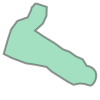

In [3]:
# load shape files

gdf = gpd.read_file(area_shp_path) # Load the shapefile
for idx, row in gdf.iterrows():
    geom = row.geometry
    if geom.geom_type == 'Polygon':
         polygon = np.array(geom.exterior.coords)



# Example polygon (triangle)
area_polygon = Polygon(polygon)
area_polygon


In [25]:
# This step is done once to read mesh topology information from the out2d file, which is needed for subsetting other STOFS files.
ds_out2d = xr.open_dataset(
    fs.open(
        f"s3://{atl_bucket_name}/{atl_S3_dir}/stofs_3d_atl.{date}/stofs_3d_atl.t12z.fields.out2d_f001_012.nc"
    ),
    chunks={},
    engine='h5netcdf'
)

ref_ds_out2d = ds_out2d.rename({'nSCHISM_hgrid_node': 'node', 'nSCHISM_hgrid_face': 'nele', 'nMaxSCHISM_hgrid_face_nodes': 'nvertex', 'SCHISM_hgrid_face_nodes':'element', 'nSCHISM_hgrid_edge':'edge'})
ref_ds_out2d = ref_ds_out2d.rename({'SCHISM_hgrid_node_x': 'x', 'SCHISM_hgrid_node_y': 'y'})

# List of variable names to add
vars_to_add = ['element','x','y']
selected_vars = ref_ds_out2d[vars_to_add]

ref_ds_out2d


<xarray.Dataset> Size: 2GB
Dimensions:                  (time: 12, node: 2926236,
                              nSCHISM_vgrid_layers: 49, one: 1, nele: 5654157,
                              edge: 8580540, nvertex: 4, two: 2)
Coordinates:
  * time                     (time) datetime64[ns] 96B 2025-05-22T13:00:00 .....
    x                        (node) float64 23MB dask.array<chunksize=(2926236,), meta=np.ndarray>
    y                        (node) float64 23MB dask.array<chunksize=(2926236,), meta=np.ndarray>
    SCHISM_hgrid_face_x      (nele) float64 45MB dask.array<chunksize=(5654157,), meta=np.ndarray>
    SCHISM_hgrid_face_y      (nele) float64 45MB dask.array<chunksize=(5654157,), meta=np.ndarray>
    SCHISM_hgrid_edge_x      (edge) float64 69MB dask.array<chunksize=(8580540,), meta=np.ndarray>
    SCHISM_hgrid_edge_y      (edge) float64 69MB dask.array<chunksize=(8580540,), meta=np.ndarray>
Dimensions without coordinates: node, nSCHISM_vgrid_layers, one, nele, edge,
                                nvertex, two
Data variables: (12/19)
    elevation                (time, node) float32 140MB dask.array<chunksize=(1, 975412), meta=np.ndarray>
    vgrid_dummy              (nSCHISM_vgrid_layers) float64 392B dask.array<chunksize=(49,), meta=np.ndarray>
    minimum_depth            (one) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    SCHISM_hgrid             (one) |S1 1B dask.array<chunksize=(1,), meta=np.ndarray>
    crs                      (one) int32 4B dask.array<chunksize=(1,), meta=np.ndarray>
    depth                    (node) float32 12MB dask.array<chunksize=(2926236,), meta=np.ndarray>
    ...                       ...
    windSpeedY               (time, node) float32 140MB dask.array<chunksize=(1, 975412), meta=np.ndarray>
    windStressX              (time, node) float32 140MB dask.array<chunksize=(1, 975412), meta=np.ndarray>
    windStressY              (time, node) float32 140MB dask.array<chunksize=(1, 975412), meta=np.ndarray>
    dryFlagElement           (time, nele) float32 271MB dask.array<chunksize=(1, 942360), meta=np.ndarray>
    dryFlagSide              (time, edge) float32 412MB dask.array<chunksize=(1, 953394), meta=np.ndarray>
    idmask                   (node) int32 12MB dask.array<chunksize=(2926236,), meta=np.ndarray>
Attributes:
    NCO:                        netCDF Operators version 4.9.7 (Homepage = ht...
    history_of_appended_files:  Thu May 22 18:43:18 2025: Appended file /lfs/...
    history:                    Thu May 22 18:44:09 2025: ncatted -O -a missi...

In [12]:
# subsetting function usinsg Thalassa package

def subset_thalassa(ds, box):
    """
    Function to subset a thalassa Dataset based on a polygon using shapely.
    
    Parameters:
    - ds: thalassa Dataset containing the data
    - polygon: shapely polygon
    
    Returns:
    - new_ds: Subset of the input dataset within the specified polygon
    """
    new_ds = thalassa.crop(ds, box)  # Crop the dataset using the bounding box
    return new_ds


In [19]:
# subsetting specified STOFS data and saving the .nc files 

for variable in variables:

    # Create the output directory if it does not exist
    os.makedirs(output_path, exist_ok=True)
    
    for hours in range(0,F_hours, 12):
        hr_start = hours+1
        hr_end = hours+12

        if variable == 'out2d':
           # Open the dataset from NODD s3 bucket directly
           ds = xr.open_dataset(
                     fs.open(f"s3://{atl_bucket_name}/{atl_S3_dir}/stofs_3d_atl.{date}/stofs_3d_atl.t12z.fields.{variable}_f0{hr_start:02d}_0{hr_end:02d}.nc"),
                     chunks={},
                     engine='h5netcdf',
                     drop_variables=['nvel']
                     )
           ds = ds.rename({'nSCHISM_hgrid_node': 'node', 'nSCHISM_hgrid_face': 'nele', 'nMaxSCHISM_hgrid_face_nodes': 'nvertex', 'SCHISM_hgrid_face_nodes':'element', 'nSCHISM_hgrid_edge':'edge'})
           ds = ds.rename({'SCHISM_hgrid_node_x': 'x', 'SCHISM_hgrid_node_y': 'y'}) 
           ds = thalassa.normalize(ds) 
           ds_subset = subset_thalassa(ds, area_polygon)  # Subset the Thalassa dataset

           # the following steps remove or change subset data variable names to SCHISM orignial names
            
           unwanted_dims = {"face", "edge"}  #dimensions we want to remove
             
           vars_to_drop = [var for var in ds_subset.data_vars if any(dim in unwanted_dims for dim in ds_subset[var].dims)]     # Drop variables and unwanted dimensions

           coords_to_drop = [coord for coord in ds_subset.coords
                  if any(dim in unwanted_dims for dim in ds_subset[coord].dims)]

           ds_cleaned = ds_subset.drop_vars(vars_to_drop + coords_to_drop)
           
           ds_schism = ds_cleaned.rename({
            'node': 'nSCHISM_hgrid_node',
            'triface': 'nSCHISM_hgrid_face',
            'three': 'nMaxSCHISM_hgrid_face_nodes',
            'triface_nodes': 'SCHISM_hgrid_face_nodes',
            'lon': 'SCHISM_hgrid_node_x',
            'lat': 'SCHISM_hgrid_node_y',
                })
           # save the subset data
           ds_schism.to_netcdf(f"{output_path}/{variable}_{date}_0{hr_start:02d}_0{hr_end:02d}.nc")
        else:
           # Open the dataset from NODD s3 bucket directly
           ds = xr.open_dataset(
                     fs.open(f"s3://{atl_bucket_name}/{atl_S3_dir}/stofs_3d_atl.{date}/stofs_3d_atl.t12z.fields.{variable}_f0{hr_start:02d}_0{hr_end:02d}.nc"),
                     chunks={},
                     engine='h5netcdf',
                     drop_variables=['nvel']
                     )
           ds = ds.rename({'nSCHISM_hgrid_node': 'node'})            
           ds = ds.merge(selected_vars)
           ds = thalassa.normalize(ds) 
           ds_subset = subset_thalassa(ds, area_polygon)  # Subset the Thalassa dataset
           
           # the following steps remove or change subset data variable names to SCHISM orignial names
           unwanted_dims = {"face", "edge"}  #dimensions we want to remove
             
           vars_to_drop = [var for var in ds_subset.data_vars if any(dim in unwanted_dims for dim in ds_subset[var].dims)]     # Drop variables and unwanted dimensions

           coords_to_drop = [coord for coord in ds_subset.coords
                  if any(dim in unwanted_dims for dim in ds_subset[coord].dims)]

           ds_cleaned = ds_subset.drop_vars(vars_to_drop + coords_to_drop)
           
           ds_schism = ds_cleaned.rename({
            'node': 'nSCHISM_hgrid_node',
            'triface': 'nSCHISM_hgrid_face',
            'three': 'nMaxSCHISM_hgrid_face_nodes',
            'triface_nodes': 'SCHISM_hgrid_face_nodes',
            'lon': 'SCHISM_hgrid_node_x',
            'lat': 'SCHISM_hgrid_node_y',
                })
            
           # save the subset data
           ds_schism.to_netcdf(f"{output_path}/{variable}_{date}_0{hr_start:02d}_0{hr_end:02d}.nc")
            
        print(f"{variable}_{date}_{hr_start:02d}_{hr_end:02d}.nc is saved!")

out2d_20250522_01_12.nc is saved!
out2d_20250522_13_24.nc is saved!
out2d_20250522_25_36.nc is saved!
out2d_20250522_37_48.nc is saved!
verticalVelocity_20250522_01_12.nc is saved!
verticalVelocity_20250522_13_24.nc is saved!
verticalVelocity_20250522_25_36.nc is saved!
verticalVelocity_20250522_37_48.nc is saved!
diffusivity_20250522_01_12.nc is saved!
diffusivity_20250522_13_24.nc is saved!
diffusivity_20250522_25_36.nc is saved!
diffusivity_20250522_37_48.nc is saved!
horizontalVelX_20250522_01_12.nc is saved!
horizontalVelX_20250522_13_24.nc is saved!
horizontalVelX_20250522_25_36.nc is saved!
horizontalVelX_20250522_37_48.nc is saved!
horizontalVelY_20250522_01_12.nc is saved!
horizontalVelY_20250522_13_24.nc is saved!
horizontalVelY_20250522_25_36.nc is saved!
horizontalVelY_20250522_37_48.nc is saved!
salinity_20250522_01_12.nc is saved!
salinity_20250522_13_24.nc is saved!
salinity_20250522_25_36.nc is saved!
salinity_20250522_37_48.nc is saved!
temperature_20250522_01_12.nc is

In [24]:

## Open out2d and the shapefile that will be used to set the mesh boundaries
boundary = gpd.read_file(boundary_shp_path) 
ds = xr.open_dataset(f'{output_path}/out2d_{date}_001_012.nc')

## Extract values to construct the mesh:
x,y,z,connect= ds.SCHISM_hgrid_node_x.values,ds.SCHISM_hgrid_node_y.values,ds.depth.values,ds.SCHISM_hgrid_face_nodes.values
## Build the mesh:
mesh = ocsmesh.utils.msht_from_numpy(np.vstack([x,y]).T, triangles=connect)#, quadrilaterals=quad-1)
mesh.value = z #assign depths to the mesh
mesh = ocsmesh.Mesh(mesh) # mesh build
#mesh.write(path+"stofs_mesh_sub_noBound.gr3", format='grd', overwrite=True)  ### Optinal if you want to save the mesh without boundaries

## Add boundaries to the mesh:
mesh.boundaries.auto_generate(threshold=-99999)
mesh.boundaries.set_open(boundary.union_all(), merge=True)
mesh.write(f'{output_path}/{name}_mesh_sub.gr3', format='grd', overwrite=True) #save mesh